# Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')

# Reading in the dataset

In [ ]:
import pandas as pd
df=pd.read_csv('/content/TexasTurbine.csv')
df.head()

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
0,"Jan 1, 12:00 am",1766.64,9.926,128,1.000480,18.263
1,"Jan 1, 01:00 am",1433.83,9.273,135,0.999790,18.363
2,"Jan 1, 02:00 am",1167.23,8.660,142,0.999592,18.663
3,"Jan 1, 03:00 am",1524.59,9.461,148,0.998309,18.763
4,"Jan 1, 04:00 am",1384.28,9.184,150,0.998507,18.963


# Data preprocessing

In [ ]:
from datetime import datetime

def con_date(x):
    d = datetime.strptime(x, '%b %d, %I:%M %p')
    return(pd.to_datetime(d.replace(year=d.year + 120)))

df['time_stamp'] = df['Time stamp'].apply(lambda x : con_date(x))
df = df.set_index('time_stamp')

In [ ]:
df.head()

,power,wind_speed,wind_direction,pressure,temperature
time_stamp,,,,,
2020-01-01 00:00:00,1766.64,9.926,128.0,1.000480,18.263
2020-01-01 01:00:00,1433.83,9.273,135.0,0.999790,18.363
2020-01-01 02:00:00,1167.23,8.660,142.0,0.999592,18.663
2020-01-01 03:00:00,1524.59,9.461,148.0,0.998309,18.763
2020-01-01 04:00:00,1384.28,9.184,150.0,0.998507,18.963


In [ ]:
df.dtypes

Time stamp                        object
System power generated | (kW)    float64
Wind speed | (m/s)               float64
Wind direction | (deg)             int64
Pressure | (atm)                 float64
Air temperature | ('C)           float64
dtype: object

In [ ]:
df.drop('Time stamp', axis=1, inplace=True)
df = df.asfreq('H')
df = df.fillna(method='ffill')

In [ ]:
df.isna().sum()

System power generated | (kW)    0
Wind speed | (m/s)               0
Wind direction | (deg)           0
Pressure | (atm)                 0
Air temperature | ('C)           0
dtype: int64

In [ ]:
df.rename({
    'System power generated | (kW)': 'power',
    'Wind speed | (m/s)': 'wind_speed',
    'Wind direction | (deg)': 'wind_direction',
    'Pressure | (atm)': 'pressure',
    'Air temperature | (\'C)': 'temperature'
}, inplace=True, axis=1)

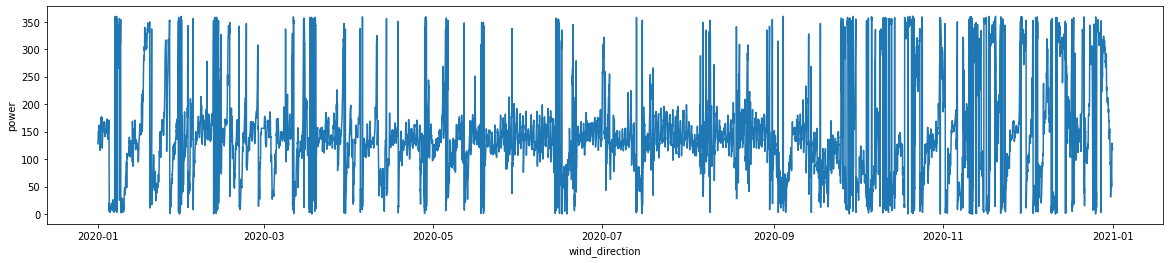

In [ ]:
plt.figure(figsize=(20,4))
ax=plt.gca()
ax.set_xlabel('wind_direction')
ax.set_ylabel('power')
plt.plot(df.index,df['wind_direction'])

# Installing pmdarima

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.6 MB/s 
     |████████████████████████████████| 9.8 MB 40.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

In [ ]:
train = df['power'][:7000]
test = df['power'][7000:]

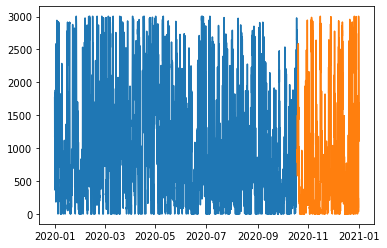

In [ ]:
plt.plot(train)
plt.plot(test)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model_auto = auto_arima(df.power,
                        exogenous = df[['wind_speed']],
                        max_order = None,
                        max_p = 2,
                        max_q = 4,
                        max_d = 1,
                        max_P = 1, 
                        max_Q = 1, 
                        max_D = 1,
                        trend = 'ct')
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8784
Model:               SARIMAX(1, 0, 4)   Log Likelihood              -56912.462
Date:                Sat, 05 Feb 2022   AIC                         113842.923
Time:                        09:19:33   BIC                         113906.649
Sample:                    01-01-2020   HQIC                        113864.634
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -5.0054      8.650     -0.579      0.563     -21.959      11.949
drift         -0.0050      0.001     -6.702      0.000      -0.006      -0.004
wind_speed   249.5904      1.053    236.946      0.0

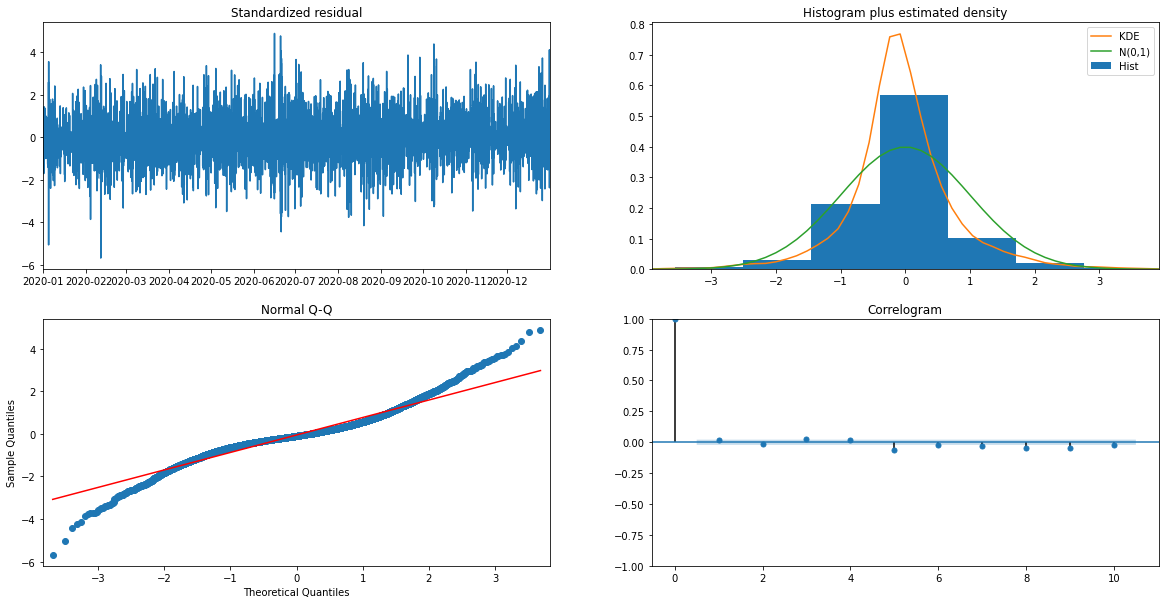

In [ ]:
model_auto.plot_diagnostics(figsize=(20,10))
plt.show()

## Predicting the next 24 hour steps

In [ ]:
steps = 24
steps_index = []
for i in range(1, (steps+1)):
    steps_index.append(df.index[-1] + pd.DateOffset(hours=i))

In [ ]:
forecast = model_auto.predict(n_periods=steps, exogenous=df[['wind_speed']][-steps:])
for i, val in enumerate(forecast):
    if val < 0:
        forecast[i] = val * -1

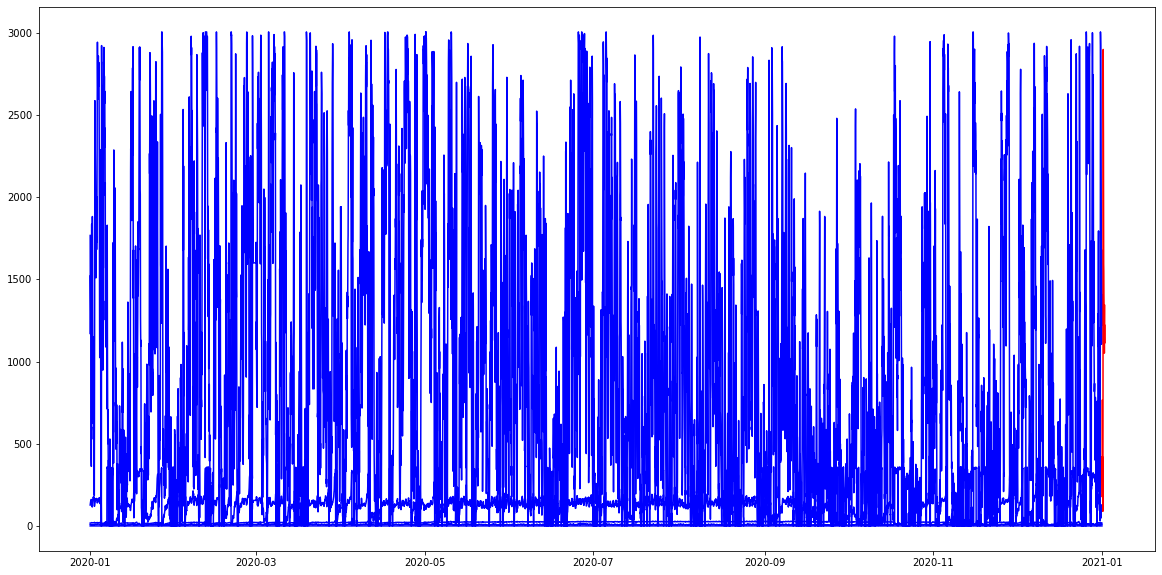

In [ ]:
model_predict = pd.DataFrame(forecast, index=steps_index, columns=['next_' + str(steps) + '_steps'])
plt.figure(figsize=(20,10))
plt.plot(df,color='blue')
plt.plot(model_predict,color='red')
plt.show()

## Output values

In [ ]:
model_predict

,next_24_steps
2021-01-01 00:00:00,763.436323
2021-01-01 01:00:00,336.220601
2021-01-01 02:00:00,176.803386
2021-01-01 03:00:00,422.848160
2021-01-01 04:00:00,307.459136
2021-01-01 05:00:00,348.118331
2021-01-01 06:00:00,129.984948
2021-01-01 07:00:00,89.883694
2021-01-01 08:00:00,600.994839
2021-01-01 09:00:00,1973.477418


In [ ]:
for i in model_predict['next_24_steps']:
  print(i)

763.4363232668162
336.2206013948089
176.80338624521346
422.84816044888544
307.45913638084767
348.1183305783153
129.9849479545246
89.88369365681353
600.994839314394
1973.4774179047688
2897.400434569073
2565.820526981996
2377.67469267696
1965.5495619074895
1592.9968524011742
1549.2767030451082
1404.579993062367
1351.57654478911
1249.7335840721796
1145.4620450761345
1051.4786649192354
1224.3504528115845
1111.2233199812797
1341.3036045395254


## Pickling

In [ ]:
import pickle

In [ ]:
filename = 'model.pkl'
pickle.dump(model_auto, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
steps = 10
steps_index = []
for i in range(1, (steps+1)):
    steps_index.append(df.index[-1] + pd.DateOffset(hours=i))

In [ ]:
forecast = loaded_model.predict(n_periods=steps, exogenous=df[['wind_speed']][-steps:])
for i, val in enumerate(forecast):
    if val < 0:
        forecast[i] = val * -1

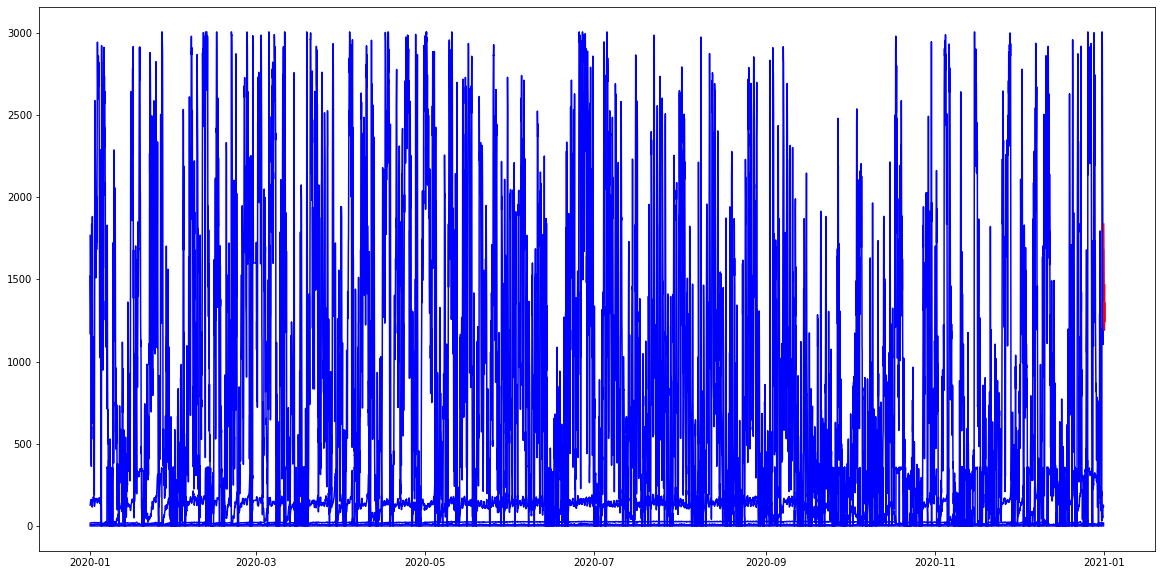

In [ ]:
model_predict = pd.DataFrame(forecast, index=steps_index, columns=['next_' + str(steps) + '_steps'])
plt.figure(figsize=(20,10))
plt.plot(df,color='blue')
plt.plot(model_predict,color='red')
plt.show()

In [ ]:
model_predict

,next_10_steps
2021-01-01 00:00:00,1836.674904
2021-01-01 01:00:00,1762.379962
2021-01-01 02:00:00,1590.483228
2021-01-01 03:00:00,1508.566259
2021-01-01 04:00:00,1400.664946
2021-01-01 05:00:00,1290.571559
2021-01-01 06:00:00,1190.993601
2021-01-01 07:00:00,1358.489209
2021-01-01 08:00:00,1240.195771
2021-01-01 09:00:00,1465.311429


In [ ]:
df.tail()

,power,wind_speed,wind_direction,pressure,temperature
time_stamp,,,,,
2020-12-31 19:00:00,1234.70,8.848,129.0,0.998604,19.663
2020-12-31 20:00:00,1105.37,8.502,118.0,1.000090,19.063
2020-12-31 21:00:00,1405.71,9.224,117.0,0.998408,18.463
2020-12-31 22:00:00,1221.36,8.799,116.0,0.998013,18.063
2020-12-31 23:00:00,1676.77,9.748,121.0,1.000380,18.163


In [ ]:
forecast.shape

(10,)

In [ ]:
round(forecast[0])

1837

In [ ]:
for i in forecast:
  print(str(i)+"\n")

1836.6749038941398

1762.3799617912105

1590.483228262228

1508.5662594555963

1400.6649464151913

1290.5715585896583

1190.9936005700486

1358.4892094548982

1240.1957707066208

1465.3114294961103

